# Wrangle Exercises

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from env import host, user, password

<hr style="border:2px solid gray">

# Part I: Zillow

## Acquire and Summarize

### #1. Acquire data from the cloud database.

You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available. You will end up using all the tables in the database.

Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid. 
   - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) 
   - Only include properties that have a latitude and longitude value.

In [2]:
#URL function
def get_db_url(host, user, password, database):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
#use our function inside env to create the url
url = get_db_url(host, user, password, 'zillow')

#Create the SQL query
query = '''
        SELECT prop.*,
        predictions_2017.logerror,
        predictions_2017.transactiondate,
        air.airconditioningdesc,
        arch.architecturalstyledesc,
        build.buildingclassdesc,
        heat.heatingorsystemdesc,
        land.propertylandusedesc,
        story.storydesc,
        type.typeconstructiondesc
        FROM properties_2017 prop
        JOIN (
            SELECT parcelid, MAX(transactiondate) AS max_transactiondate
            FROM predictions_2017
            GROUP BY parcelid
            ) pred USING(parcelid)
        JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                          AND pred.max_transactiondate = predictions_2017.transactiondate
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
        WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL
        '''

In [4]:
#create the dataframe using the sql query and our url
df = pd.read_sql(query, url)

In [5]:
#take a look
df.head(3)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,None,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,None,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,None,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,None


<hr style="border:1px solid black">

### #2. Summariaze your data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52319 non-null  int64  
 1   parcelid                      52319 non-null  int64  
 2   airconditioningtypeid         13615 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52319 non-null  float64
 6   bedroomcnt                    52319 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         33654 non-null  float64
 9   calculatedbathnbr             52184 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4371 non-null   float64
 12  calculatedfinishedsquarefeet  52238 non-null  float64
 13  f

In [7]:
df.isnull().sum()

id                              0
parcelid                        0
airconditioningtypeid       38704
architecturalstyletypeid    52249
basementsqft                52272
                            ...  
buildingclassdesc           52319
heatingorsystemdesc         18470
propertylandusedesc             0
storydesc                   52272
typeconstructiondesc        52243
Length: 68, dtype: int64

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,52319.0,1.496888e+06,8.594310e+05,3.490000e+02,7.575810e+05,1.500095e+06,2.241248e+06,2.982270e+06
parcelid,52319.0,1.299682e+07,3.350951e+06,1.071186e+07,1.151017e+07,1.257825e+07,1.413036e+07,1.676878e+08
airconditioningtypeid,13615.0,2.439589e+00,3.847925e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,70.0,7.100000e+00,2.665670e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,47.0,6.789787e+02,7.118252e+02,3.800000e+01,2.635000e+02,5.120000e+02,8.095000e+02,3.560000e+03
bathroomcnt,52319.0,2.300015e+00,1.022816e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,52319.0,3.300770e+00,9.475632e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
buildingqualitytypeid,33654.0,6.264961e+00,1.716328e+00,1.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,52184.0,2.305276e+00,1.018076e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,389.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [9]:
df.shape

(52319, 68)

<hr style="border:1px solid black">

### #3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name 
- The first column is the number of rows with missing values for that attribute
- The second column is percent of total rows that have missing values for that attribute. 
- Run the function and document takeaways from this on how you want to handle missing values.

In [10]:
#Create the function
def null_counter(df):
    '''
    This function takes in a dataframe
    then calculate number and percent of values missing from each column
    and returns a dataframe with that information
    '''
    #name our columns
    new_columns = ['name', 'num_rows_missing', 'pct_rows_missing']
    
    #turn those columns into a dataframe
    new_df = pd.DataFrame(columns=new_columns)
    
    #create the for loop
    for col in list(df.columns):
        #that gets a sum of nulls in each column
        num_missing = df[col].isna().sum()
        #and the percentage of those missing values
        pct_missing = num_missing / df.shape[0]
        
        #create the dataframe with our info
        add_df = pd.DataFrame([{'name': col, 'num_rows_missing': num_missing,
                               'pct_rows_missing': pct_missing}])
        
        #and combine that with our initial dataframe
        new_df = pd.concat([new_df, add_df], axis=0)
    
    #set the index on name
    new_df.set_index('name', inplace=True)
    
    return new_df

In [11]:
#call the function we just created
null_df = null_counter(df)

#take a look
null_df.sort_values(by='pct_rows_missing', ascending=False)

,num_rows_missing,pct_rows_missing
name,,
buildingclassdesc,52319,1.000000
buildingclasstypeid,52319,1.000000
finishedsquarefeet15,52319,1.000000
finishedsquarefeet13,52319,1.000000
storytypeid,52272,0.999102
...,...,...
latitude,0,0.000000
fips,0,0.000000
bedroomcnt,0,0.000000


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>
    <br>
We may want to consider dropping some of the columns that have a high percent of nulls in them.
</div>

<hr style="border:1px solid black">
<hr style="border:1px solid black">

## Prepare

### #1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). 
- There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.
- ```propertylandusetypeid``` already tells us they are single unit properties <b>but</b> what if we didn't have this feature?? 

In [12]:
df.propertylandusetypeid.value_counts()

261.0    52319
Name: propertylandusetypeid, dtype: int64

<div class="alert alert-block alert-info">
<b>Note:</b> 
<br>
    
There are many ways to determine this.

</div>

In [13]:
#Maybe there are some houses with no square footage?
no_sqft = df[df['calculatedfinishedsquarefeet'] == 0]
len(no_sqft)

0

In [14]:
#What about nonexistent lots?
no_lot = df[df['lotsizesquarefeet'] == 0]
len(no_lot)

0

In [15]:
#Maybe ones that have no bedrooms?
no_beds = df[df['bedroomcnt'] == 0]
len(no_beds)

135

In [16]:
#Maybe ones that have no bedrooms?
no_bath = df[df['bathroomcnt'] == 0]
len(no_bath)

119

<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>
    <br>   
We may be able to determine that a home with:
<br>
    
- No square footage
<br>
- No lot
<br>
- No bedrooms
<br>
- No bathrooms
<br>
<br>
... is likely not a single family home?    
</div>

### #2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

In [17]:
#Define 
def null_dropper(df, prop_required_column, prop_required_row):
    '''
    This function takes in a dataframe, 
    proportion of required columns and rows
    then it returns a dataframe with the columns/rows dropped 
    that are above that determined threshold
    '''
    prop_null_column = 1 - prop_required_column
    
    for col in list(df.columns):
        
        null_sum = df[col].isna().sum()
        null_pct = null_sum / df.shape[0]
        
        if null_pct > prop_null_column:
            df.drop(columns=col, inplace=True)
            
    row_threshold = int(prop_required_row * df.shape[1])
    
    df.dropna(axis=0, thresh=row_threshold, inplace=True)
    
    return df

In [18]:
#Let's use our function
clean_df = null_dropper(df, 0.75, 0.75)

#take a look
clean_df.head(3)

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,1727539,14297519,3.5,4.0,3.5,3100.0,3100.0,6059.0,3.0,33634931.0,...,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,Single Family Residential
1,1387261,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,11677,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential


In [19]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52317 entries, 0 to 52318
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52317 non-null  int64  
 1   parcelid                      52317 non-null  int64  
 2   bathroomcnt                   52317 non-null  float64
 3   bedroomcnt                    52317 non-null  float64
 4   calculatedbathnbr             52184 non-null  float64
 5   calculatedfinishedsquarefeet  52238 non-null  float64
 6   finishedsquarefeet12          52073 non-null  float64
 7   fips                          52317 non-null  float64
 8   fullbathcnt                   52184 non-null  float64
 9   latitude                      52317 non-null  float64
 10  longitude                     52317 non-null  float64
 11  lotsizesquarefeet             51953 non-null  float64
 12  propertycountylandusecode     52317 non-null  object 
 13  p

In [20]:
#use our function to see how many nulls we have left
null_clean = null_counter(clean_df)

#take a look at top 10 null columns
null_clean.sort_values(by='pct_rows_missing', ascending=False).head(10)

,num_rows_missing,pct_rows_missing
name,,
regionidcity,1034,0.019764
lotsizesquarefeet,364,0.006958
finishedsquarefeet12,244,0.004664
calculatedbathnbr,133,0.002542
fullbathcnt,133,0.002542
censustractandblock,119,0.002275
yearbuilt,112,0.002141
structuretaxvaluedollarcnt,80,0.001529
calculatedfinishedsquarefeet,79,0.001510


In [21]:
clean_df.shape

(52317, 29)

<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>
    <br>   
The "clean" dataframe contains:
<br>
    
- 29 columns instead of 68 columns
<br>
- At the most, we have a column with 2% nulls instead of 100% nulls
<br>
- The dataframe shape changed from (52319, 68) to (52317, 29)
</div>

### #3. Encapsulate your work inside of functions in a wrangle_zillow.py module.

<hr style="border:2px solid gray">
<hr style="border:2px solid gray">

# Part II: Mall Customers

### #1. Acquire data from the customers table in the mall_customers database.

In [22]:
#create the sql query
mall_query = '''
             SELECT *
             FROM customers
             '''

In [23]:
#create url for mall acquisition
mall_url = get_db_url(host, user, password, 'mall_customers')

In [24]:
#Read in the dataset
mall_df = pd.read_sql(mall_query, mall_url)

In [25]:
mall_df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### #2. Summarize the data (include distributions and descriptive statistics).

In [26]:
mall_df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
annual_income,200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
spending_score,200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [27]:
mall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


customer_id


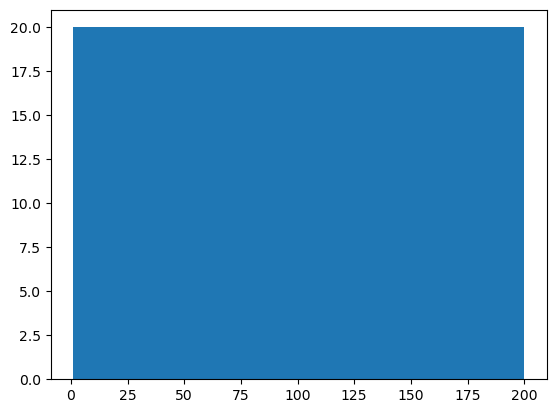

gender


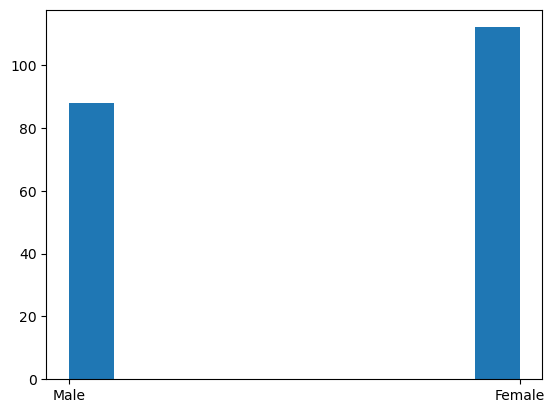

age


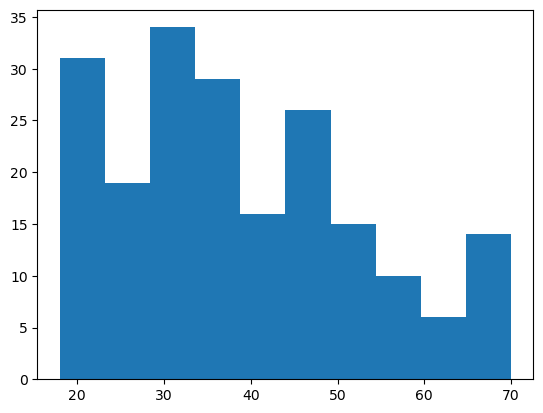

annual_income


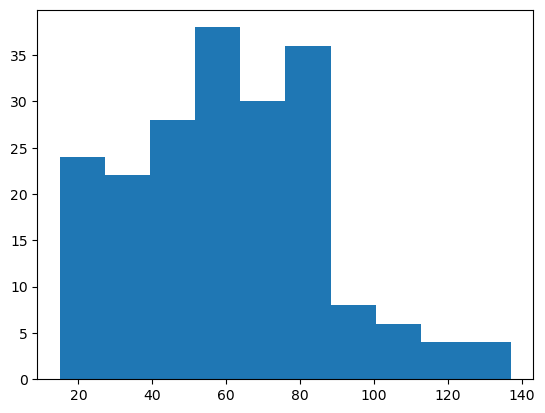

spending_score


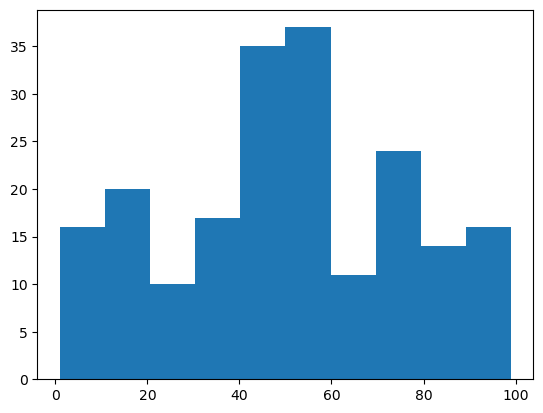

In [28]:
#Visualize distribution of variables
cols = mall_df.columns.to_list()    

for col in cols:
    plt.hist(mall_df[col])
    print(f'{col}')
    plt.show()

### #3. Detect outliers using IQR.

<div class="alert alert-block alert-info">
<b>Note:</b> 
<br>

<b>Quartiles</b>
<br>
- data is split into 4 equal parts
<br>
- a quartile represents one of these bins that captures exactly 25% of the data 
<br>
- 25% / 25% / 25% / 25%
<br>
    
<b>Bounds/IQR</b>    
- lower bound: Q1-(k*IQR)
<br>
- upper bound: Q3+(k*IQR)
    

</div>

In [29]:
#let's find our quantiles for age
mall_df['age'].quantile([0.25,0.75])

0.25    28.75
0.75    49.00
Name: age, dtype: float64

In [30]:
#another way to do this, numpy percentile function
q1, q3= np.percentile(mall_df['age'], [25, 75])
q1, q3

(28.75, 49.0)

In [31]:
#yet another way to do this, numpy quantile function
q1, q3 = np.quantile(mall_df['age'], [0.25, 0.75])
q1, q3

(28.75, 49.0)

In [32]:
#create a function to calculate outliers
def outlier_bound_calculation(df, variable):
    '''
    This function calcualtes the lower and upper bound 
    to locate outliers in the variable named
    '''
    quartile1, quartile3 = np.percentile(df[variable], [25,75])
    IQR_value = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * IQR_value)
    upper_bound = quartile3 + (1.5 * IQR_value)
    '''
    returns the lowerbound and upperbound values
    '''
    return print(f'For {variable} the lower bound is {lower_bound} and  upper bound is {upper_bound}')

In [33]:
age_outliers = outlier_bound_calculation(mall_df, 'age')

For age the lower bound is -1.625 and  upper bound is 79.375


In [34]:
#identify numeric columns only
num_df = mall_df.select_dtypes(exclude=object)
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   customer_id     200 non-null    int64
 1   age             200 non-null    int64
 2   annual_income   200 non-null    int64
 3   spending_score  200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


In [35]:
##identify discrete columns only
disc_df = mall_df.select_dtypes(include=object)
disc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  200 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


In [36]:
#let's iterate through the list of numeric columns 
##to find the upper and lower bounds
cols = num_df.columns.to_list()    

for col in cols:
    outlier_bound_calculation(num_df, [col])

For ['customer_id'] the lower bound is -98.5 and  upper bound is 299.5
For ['age'] the lower bound is -1.625 and  upper bound is 79.375
For ['annual_income'] the lower bound is -13.25 and  upper bound is 132.75
For ['spending_score'] the lower bound is -22.625 and  upper bound is 130.375


### #4. Split data into train, validate, and test.

In [37]:
#function from wrangle.py
def split_data(df, target):
    '''
    This function take in a dataframe performs a train, validate, test split
    Returns train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test
    and prints out the shape of train, validate, test
    '''
    #create train_validate and test datasets
    train, test = train_test_split(df, train_size = 0.8, random_state = 123)
    #create train and validate datasets
    train, validate = train_test_split(train, train_size = 0.7, random_state = 123)

    #Split into X and y
    X_train = train.drop(columns=[target])
    y_train = train[target]

    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]

    X_test = test.drop(columns=[target])
    y_test = test[target]

    # Have function print datasets shape
    print(f'train -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test -> {test.shape}')
   
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [38]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = split_data(mall_df, 'spending_score')

train -> (112, 5)
validate -> (48, 5)
test -> (40, 5)


### #5. Encode categorical columns using a one hot encoder (pd.get_dummies).

<div class="alert alert-block alert-info">
<b>Note:</b> 
<br>
    
- The only column in this data that needs to be encoded is gender.

</div>

In [39]:
#Check get_dummies works as expected on my training data
dummy_df = pd.get_dummies(train)
dummy_df

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male
123,124,39,69,91,0,1
76,77,45,54,53,1,0
171,172,28,87,75,0,1
10,11,67,19,14,0,1
35,36,21,33,81,1,0
...,...,...,...,...,...,...
175,176,30,88,86,1,0
101,102,49,62,48,1,0
148,149,34,78,22,1,0
99,100,20,61,49,0,1


In [40]:
def encoding(df, cols, drop_first=True):
    '''
    Take in df and list of columns
    add encoded columns derived from columns in list to the df
    '''
    for col in cols:

        dummies = pd.get_dummies(df[f'{col}'], drop_first=drop_first) # get dummy columns

        df = pd.concat([df, dummies], axis=1) # add dummy columns to df
        
    return df

In [41]:
train_encoded = encoding(train, disc_df , drop_first=True)

In [42]:
train_encoded

,customer_id,gender,age,annual_income,spending_score,Male
123,124,Male,39,69,91,1
76,77,Female,45,54,53,0
171,172,Male,28,87,75,1
10,11,Male,67,19,14,1
35,36,Female,21,33,81,0
...,...,...,...,...,...,...
175,176,Female,30,88,86,0
101,102,Female,49,62,48,0
148,149,Female,34,78,22,0
99,100,Male,20,61,49,1


### #6. Handles missing values.

In [43]:
#count of nulls in the df
mall_df.isnull().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [44]:
#use null value counter function
null_malldf = null_counter(mall_df)

#take a look
null_malldf.sort_values(by='pct_rows_missing', ascending=False)

,num_rows_missing,pct_rows_missing
name,,
customer_id,0,0.0
gender,0,0.0
age,0,0.0
annual_income,0,0.0
spending_score,0,0.0


### #7.Scaling

In [45]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 123 to 22
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     112 non-null    int64 
 1   gender          112 non-null    object
 2   age             112 non-null    int64 
 3   annual_income   112 non-null    int64 
 4   spending_score  112 non-null    int64 
 5   Male            112 non-null    uint8 
dtypes: int64(4), object(1), uint8(1)
memory usage: 5.4+ KB


<div class="alert alert-block alert-info">
<b>Note:</b> 
<br>

Only numeric columns typically need to be scaled.
<br>
- customer_id does not need to be scaled
<br>
- gender does not need to be scaled
<br>
- Male does not need to be scaled
<br>
- spending_score is our target so it also does not need to be scaled
</div>

In [46]:
#create the scaler
mms = MinMaxScaler()

#fit the scaler on the desired columns
train_encoded[['age', 'annual_income']] = mms.fit_transform(train_encoded[['age','annual_income']])

#take a look
train_encoded.head()

,customer_id,gender,age,annual_income,spending_score,Male
123,124,Male,0.403846,0.442623,91,1
76,77,Female,0.519231,0.319672,53,0
171,172,Male,0.192308,0.590164,75,1
10,11,Male,0.942308,0.032787,14,1
35,36,Female,0.057692,0.147541,81,0


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>
- We now have gender encoded (dummy variable)
<br>
- Age and annual income are scaled
</div>

<hr style="border:2px solid gray">
<hr style="border:2px solid gray">